In [89]:
import os
import matplotlib.pyplot as plt
import re
import string
import json
import emoji
import numpy as np
import pandas as pd
from sklearn import metrics
from bs4 import BeautifulSoup
import tqdm
import ktrain
from ktrain import text
import tensorflow as tf
import timeit
import transformers
import contractions
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW, TFAutoModelForSequenceClassification
import gc
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

In [90]:
df_train = pd.read_csv('https://github.com/google-research/google-research/raw/master/goemotions/data/train.tsv', sep='\t', header=None, names=['Text', 'Class', 'ID']).drop('ID', axis=1)
df_val = pd.read_csv('https://github.com/google-research/google-research/raw/master/goemotions/data/dev.tsv', sep='\t', header=None, names=['Text', 'Class', 'ID']).drop('ID', axis=1)
df_test = pd.read_csv('https://github.com/google-research/google-research/raw/master/goemotions/data/test.tsv', sep='\t', header=None, names=['Text', 'Class', 'ID']).drop('ID', axis=1)


In [91]:
df_train

,Text,Class
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3
...,...,...
43405,Added you mate well I’ve just got the bow and ...,18
43406,Always thought that was funny but is it a refe...,6
43407,What are you talking about? Anything bad that ...,3
43408,"More like a baptism, with sexy results!",13


In [92]:
df_train['List of classes'] = df_train['Class'].apply(lambda x: x.split(','))
df_train['Len of classes'] = df_train['List of classes'].apply(lambda x: len(x))
df_val['List of classes'] = df_val['Class'].apply(lambda x: x.split(','))
df_val['Len of classes'] = df_val['List of classes'].apply(lambda x: len(x))
df_test['List of classes'] = df_test['Class'].apply(lambda x: x.split(','))
df_test['Len of classes'] = df_test['List of classes'].apply(lambda x: len(x))

In [93]:
df_train

,Text,Class,List of classes,Len of classes
0,My favourite food is anything I didn't have to...,27,[27],1
1,"Now if he does off himself, everyone will thin...",27,[27],1
2,WHY THE FUCK IS BAYLESS ISOING,2,[2],1
3,To make her feel threatened,14,[14],1
4,Dirty Southern Wankers,3,[3],1
...,...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,18,[18],1
43406,Always thought that was funny but is it a refe...,6,[6],1
43407,What are you talking about? Anything bad that ...,3,[3],1
43408,"More like a baptism, with sexy results!",13,[13],1


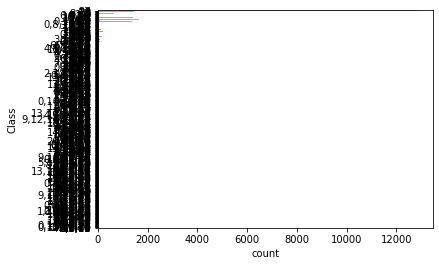

In [94]:
import seaborn as sns
sns.countplot(y=df_train['Class'],data=df_train)
plt.show()

In [95]:
df_train.isnull().sum()

Text               0
Class              0
List of classes    0
Len of classes     0
dtype: int64

In [96]:
df_train["Class"].value_counts()

27           12823
0             2710
4             1873
15            1857
1             1652
             ...  
6,15,22          1
9,10,19          1
7,10,25          1
7,9,24,25        1
0,1,18           1
Name: Class, Length: 711, dtype: int64

In [97]:
with open('ekman_mapping.json') as file:
    ekman_mapping = json.load(file)

In [98]:
emotion_file = open("emotions.txt", "r")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")
print(emotion_list)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [99]:
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

In [100]:
df_train['Emotions'] = df_train['List of classes'].apply(idx2class)
df_val['Emotions'] = df_val['List of classes'].apply(idx2class)
df_test['Emotions'] = df_test['List of classes'].apply(idx2class)

In [101]:
ekman_mapping.update({'neutral':['neutral']})

In [102]:
ekman_mapping

{'anger': ['anger', 'annoyance', 'disapproval'],
 'disgust': ['disgust'],
 'fear': ['fear', 'nervousness'],
 'joy': ['joy',
  'amusement',
  'approval',
  'excitement',
  'gratitude',
  'love',
  'optimism',
  'relief',
  'pride',
  'admiration',
  'desire',
  'caring'],
 'sadness': ['sadness', 'disappointment', 'embarrassment', 'grief', 'remorse'],
 'surprise': ['surprise', 'realization', 'confusion', 'curiosity'],
 'neutral': ['neutral']}

In [103]:
def EmotionMapping(emotion_list):
    map_list = []
    
    for i in emotion_list:
        if i in ekman_mapping['anger']:
            map_list.append('anger')
        if i in ekman_mapping['disgust']:
            map_list.append('disgust')
        if i in ekman_mapping['fear']:
            map_list.append('fear')
        if i in ekman_mapping['joy']:
            map_list.append('joy')
        if i in ekman_mapping['sadness']:
            map_list.append('sadness')
        if i in ekman_mapping['surprise']:
            map_list.append('surprise')
        if i in ekman_mapping['neutral']:
            map_list.append('neutral')
        
            
    return map_list

In [104]:
df_train['Mapped Emotions'] = df_train['Emotions'].apply(EmotionMapping)
df_val['Mapped Emotions'] = df_val['Emotions'].apply(EmotionMapping)
df_test['Mapped Emotions'] = df_test['Emotions'].apply(EmotionMapping)

In [105]:
df_train

,Text,Class,List of classes,Len of classes,Emotions,Mapped Emotions
0,My favourite food is anything I didn't have to...,27,[27],1,[neutral],[neutral]
1,"Now if he does off himself, everyone will thin...",27,[27],1,[neutral],[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,2,[2],1,[anger],[anger]
3,To make her feel threatened,14,[14],1,[fear],[fear]
4,Dirty Southern Wankers,3,[3],1,[annoyance],[anger]
...,...,...,...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,18,[18],1,[love],[joy]
43406,Always thought that was funny but is it a refe...,6,[6],1,[confusion],[surprise]
43407,What are you talking about? Anything bad that ...,3,[3],1,[annoyance],[anger]
43408,"More like a baptism, with sexy results!",13,[13],1,[excitement],[joy]


df_train_1 = df_train.copy()
df_dev_1 = df_dev.copy()
df_val_1 = df_val.copy()
df_test_1 = df_test.copy()


In [106]:
# OneHot encoding for multi-label classification
for emo in ekman_mapping:
    df_train[emo] = np.zeros((len(df_train),1))
    df_train[emo] = df_train['Mapped Emotions'].apply(lambda x: 1 if emo in x else 0)

for emo in ekman_mapping:
    df_val[emo] = np.zeros((len(df_val),1))
    df_val[emo] = df_val['Mapped Emotions'].apply(lambda x: 1 if emo in x else 0)    

for emo in ekman_mapping:
    df_test[emo] = np.zeros((len(df_test),1))
    df_test[emo] = df_test['Mapped Emotions'].apply(lambda x: 1 if emo in x else 0)

# Preview of data   
#display(df_train_1.head())

In [107]:
df_train.head(3)

,Text,Class,List of classes,Len of classes,Emotions,Mapped Emotions,anger,disgust,fear,joy,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,27,[27],1,[neutral],[neutral],0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",27,[27],1,[neutral],[neutral],0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,2,[2],1,[anger],[anger],1,0,0,0,0,0,0


In [108]:
df_train.drop(['Class','List of classes','Len of classes','Emotions','Mapped Emotions'], axis=1, inplace=True)
df_val.drop(['Class','List of classes','Len of classes','Emotions','Mapped Emotions'], axis=1, inplace=True)
df_test.drop(['Class','List of classes','Len of classes','Emotions','Mapped Emotions'], axis=1, inplace=True)

In [109]:
df_train_no_neu = df_train.copy()
df_val_no_neu = df_val.copy()
df_test_no_neu = df_test.copy()

In [110]:
df_train_no_neu = df_train_no_neu.drop(columns=['neutral'])
df_val_no_neu = df_val_no_neu.drop(columns=['neutral'])
df_test_no_neu = df_test_no_neu.drop(columns=['neutral'])

Then, we need remove all the samples that have been left without a label.

In [111]:
# Removing samples with only 0 in their labels
df_train_no_neu = df_train_no_neu.loc[ df_train_no_neu.apply(lambda x: sum(x[1:]), axis=1)>0 ]
df_val_no_neu = df_val_no_neu.loc[ df_val_no_neu.apply(lambda x: sum(x[1:]), axis=1)>0 ]
df_test_no_neu = df_test_no_neu.loc[ df_test_no_neu.apply(lambda x: sum(x[1:]), axis=1)>0 ]

# Shape validation
print(df_train_no_neu.shape)
print(df_train_no_neu.shape)
print(df_train_no_neu.shape)

(30587, 7)
(30587, 7)
(30587, 7)


In [112]:
df_train_no_neu.head(3)

,Text,anger,disgust,fear,joy,sadness,surprise
2,WHY THE FUCK IS BAYLESS ISOING,1,0,0,0,0,0
3,To make her feel threatened,0,0,1,0,0,0
4,Dirty Southern Wankers,1,0,0,0,0,0


In [113]:
# Building a preprocessing function to clean text
def preprocess_corpus(x):

  # Adding a space between words and punctation
  x = re.sub( r'([a-zA-Z\[\]])([,;.!?])', r'\1 \2', x)
  x = re.sub( r'([,;.!?])([a-zA-Z\[\]])', r'\1 \2', x)
  
  # Demojize
  x = emoji.demojize(x)
  
  # Expand contraction
  x = contractions.fix(x)
  
  # Lower
  x = x.lower()

  #correct some acronyms/typos/abbreviations  
  x = re.sub(r"lmao", "laughing my ass off", x)  
  x = re.sub(r"amirite", "am i right", x)
  x = re.sub(r"\b(tho)\b", "though", x)
  x = re.sub(r"\b(ikr)\b", "i know right", x)
  x = re.sub(r"\b(ya|u)\b", "you", x)
  x = re.sub(r"\b(eu)\b", "europe", x)
  x = re.sub(r"\b(da)\b", "the", x)
  x = re.sub(r"\b(dat)\b", "that", x)
  x = re.sub(r"\b(dats)\b", "that is", x)
  x = re.sub(r"\b(cuz)\b", "because", x)
  x = re.sub(r"\b(fkn)\b", "fucking", x)
  x = re.sub(r"\b(tbh)\b", "to be honest", x)
  x = re.sub(r"\b(tbf)\b", "to be fair", x)
  x = re.sub(r"faux pas", "mistake", x)
  x = re.sub(r"\b(btw)\b", "by the way", x)
  x = re.sub(r"\b(bs)\b", "bullshit", x)
  x = re.sub(r"\b(kinda)\b", "kind of", x)
  x = re.sub(r"\b(bruh)\b", "bro", x)
  x = re.sub(r"\b(w/e)\b", "whatever", x)
  x = re.sub(r"\b(w/)\b", "with", x)
  x = re.sub(r"\b(w/o)\b", "without", x)
  x = re.sub(r"\b(doj)\b", "department of justice", x)
  
  #replace some words with multiple occurences of a letter, example "coooool" turns into --> cool
  x = re.sub(r"\b(j+e{2,}z+e*)\b", "jeez", x)
  x = re.sub(r"\b(co+l+)\b", "cool", x)
  x = re.sub(r"\b(g+o+a+l+)\b", "goal", x)
  x = re.sub(r"\b(s+h+i+t+)\b", "shit", x)
  x = re.sub(r"\b(o+m+g+)\b", "omg", x)
  x = re.sub(r"\b(w+t+f+)\b", "wtf", x)
  x = re.sub(r"\b(w+h+a+t+)\b", "what", x)
  x = re.sub(r"\b(y+e+y+|y+a+y+|y+e+a+h+)\b", "yeah", x)
  x = re.sub(r"\b(w+o+w+)\b", "wow", x)
  x = re.sub(r"\b(w+h+y+)\b", "why", x)
  x = re.sub(r"\b(s+o+)\b", "so", x)
  x = re.sub(r"\b(f)\b", "fuck", x)
  x = re.sub(r"\b(w+h+o+p+s+)\b", "whoops", x)
  x = re.sub(r"\b(ofc)\b", "of course", x)
  x = re.sub(r"\b(the us)\b", "usa", x)
  x = re.sub(r"\b(gf)\b", "girlfriend", x)
  x = re.sub(r"\b(hr)\b", "human ressources", x)
  x = re.sub(r"\b(mh)\b", "mental health", x)
  x = re.sub(r"\b(idk)\b", "i do not know", x)
  x = re.sub(r"\b(gotcha)\b", "i got you", x)
  x = re.sub(r"\b(y+e+p+)\b", "yes", x)
  x = re.sub(r"\b(a*ha+h[ha]*|a*ha +h[ha]*)\b", "haha", x)
  x = re.sub(r"\b(o?l+o+l+[ol]*)\b", "lol", x)
  x = re.sub(r"\b(o*ho+h[ho]*|o*ho +h[ho]*)\b", "ohoh", x)
  x = re.sub(r"\b(o+h+)\b", "oh", x)
  x = re.sub(r"\b(a+h+)\b", "ah", x)
  x = re.sub(r"\b(u+h+)\b", "uh", x)

  # Handling emojis
  x = re.sub(r"<3", " love ", x)
  x = re.sub(r"xd", " smiling_face_with_open_mouth_and_tightly_closed_eyes ", x)
  x = re.sub(r":\)", " smiling_face ", x)
  x = re.sub(r"^_^", " smiling_face ", x)
  x = re.sub(r"\*_\*", " star_struck ", x)
  x = re.sub(r":\(", " frowning_face ", x)
  x = re.sub(r":\^\(", " frowning_face ", x)
  x = re.sub(r";\(", " frowning_face ", x)
  x = re.sub(r":\/",  " confused_face", x)
  x = re.sub(r";\)",  " wink", x)
  x = re.sub(r">__<",  " unamused ", x)
  x = re.sub(r"\b([xo]+x*)\b", " xoxo ", x)
  x = re.sub(r"\b(n+a+h+)\b", "no", x)

  # Handling special cases of text
  x = re.sub(r"h a m b e r d e r s", "hamberders", x)
  x = re.sub(r"b e n", "ben", x)
  x = re.sub(r"s a t i r e", "satire", x)
  x = re.sub(r"y i k e s", "yikes", x)
  x = re.sub(r"s p o i l e r", "spoiler", x)
  x = re.sub(r"thankyou", "thank you", x)
  x = re.sub(r"a^r^o^o^o^o^o^o^o^n^d", "around", x)

  # Remove special characters and numbers replace by space + remove double space
  x = re.sub(r"\b([.]{3,})"," dots ", x)
  x = re.sub(r"[^A-Za-z!?_]+"," ", x)
  x = re.sub(r"\b([s])\b *","", x)
  x = re.sub(r" +"," ", x)
  x = x.strip()

  return x

In [114]:
# Defining the number of samples in train, validation and test dataset
size_train = df_train.shape[0]
size_val = df_val.shape[0]
size_test = df_test.shape[0]

size_train_no_neu = df_train_no_neu.shape[0]
size_val_no_neu = df_val_no_neu.shape[0]
size_test_no_neu = df_test_no_neu.shape[0]

# Defining the total number of samples
size_all = size_train + size_val + size_test
size_all_no_neu = size_train_no_neu + size_val_no_neu + size_test_no_neu

In [115]:
size_train, 

(43410,)

In [116]:
size_train_no_neu, size_val_no_neu, size_test_no_neu

(30587, 3834, 3821)

In [117]:
# Shape of train, validation and test datasets
print("Train dataset has {} samples and represents {:.2f}% of overall data".format(size_train, size_train/size_all*100))
print("Validation dataset has {} samples and represents {:.2f}% of overall data".format(size_val, size_val/size_all*100))
print("Test dataset has {} samples and represents {:.2f}% of overall data".format(size_test, size_test/size_all*100))
print()
print("The total number of samples is : {}".format(size_all))

Train dataset has 43410 samples and represents 80.00% of overall data
Validation dataset has 5426 samples and represents 10.00% of overall data
Test dataset has 5427 samples and represents 10.00% of overall data

The total number of samples is : 54263


In [118]:
# Concatenating the 3 datasets for labels preprocessing
df_all = pd.concat([df_train, df_val, df_test], axis=0).reset_index(drop=True)
df_all_no_neu = pd.concat([df_train_no_neu, df_val_no_neu, df_test_no_neu], axis=0).reset_index(drop=True)

# Preview of data
display(df_all.head(5))
display(df_all_no_neu.head(5))
print(df_all.shape)
print(df_all_no_neu.shape)

,Text,anger,disgust,fear,joy,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,1,0,0,0,0,0,0
3,To make her feel threatened,0,0,1,0,0,0,0
4,Dirty Southern Wankers,1,0,0,0,0,0,0


,Text,anger,disgust,fear,joy,sadness,surprise
0,WHY THE FUCK IS BAYLESS ISOING,1,0,0,0,0,0
1,To make her feel threatened,0,0,1,0,0,0
2,Dirty Southern Wankers,1,0,0,0,0,0
3,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,0,0,0,0,0,1
4,Yes I heard abt the f bombs! That has to be wh...,0,0,0,1,0,0


(54263, 8)
(38242, 7)


In [119]:
# Applying the preprocessing function on the dataset
df_all["Clean_text"] = df_all["Text"].apply(preprocess_corpus)
df_all_no_neu["Clean_text"] = df_all_no_neu["Text"].apply(preprocess_corpus)

# Preview of data
display(df_all[['Text', 'Clean_text']].sample(5))
display(df_all_no_neu[['Text', 'Clean_text']].sample(5))

,Text,Clean_text
51661,I didn’t know [NAME] disliked Pittsburgh so much,i did not know name disliked pittsburgh so much
43386,Wait and do what ever it takes to get [NAME],wait and do what ever it takes to get name
34022,Come to Nashville. Love to help with that prob...,come to nashville love to help with that problem
29022,"Thanks for that. It seemed fishy, but it is wh...",thanks for that it seemed fishy but it is what...
8874,I'd rather just let them fester over there and...,i would rather just let them fester over there...


,Text,Clean_text
35874,Dude you really like The Strokes.,dude you really like the strokes
27555,Ignorance is bliss,ignorance is bliss
12373,Fucking hell! I've been out there protesting o...,fucking hell ! i have been out there protestin...
28110,Thank you for that :) I'm not OP but I am real...,thank you for that smiling_face i am not op bu...
11169,I'm sure the two young sons of [NAME] are comf...,i am sure the two young sons of name are comfo...


In [120]:
display(df_all.head(3))
display(df_all_no_neu.head(3))

,Text,anger,disgust,fear,joy,sadness,surprise,neutral,Clean_text
0,My favourite food is anything I didn't have to...,0,0,0,0,0,0,1,my favourite food is anything i did not have t...
1,"Now if he does off himself, everyone will thin...",0,0,0,0,0,0,1,now if he does off himself everyone will think...
2,WHY THE FUCK IS BAYLESS ISOING,1,0,0,0,0,0,0,why the fuck is bayless isoing


,Text,anger,disgust,fear,joy,sadness,surprise,Clean_text
0,WHY THE FUCK IS BAYLESS ISOING,1,0,0,0,0,0,why the fuck is bayless isoing
1,To make her feel threatened,0,0,1,0,0,0,to make her feel threatened
2,Dirty Southern Wankers,1,0,0,0,0,0,dirty southern wankers


In [121]:
# Keeping only necessary columns
#df_all = df_all.drop(['Class','List of classes','Len of classes','Emotions'], axis=1)
df_all.head(3)

,Text,anger,disgust,fear,joy,sadness,surprise,neutral,Clean_text
0,My favourite food is anything I didn't have to...,0,0,0,0,0,0,1,my favourite food is anything i did not have t...
1,"Now if he does off himself, everyone will thin...",0,0,0,0,0,0,1,now if he does off himself everyone will think...
2,WHY THE FUCK IS BAYLESS ISOING,1,0,0,0,0,0,0,why the fuck is bayless isoing


In [122]:
# Dropping raw text column
df_all = df_all[ ['Clean_text','anger','disgust','fear','joy','sadness','surprise','neutral'] ]
df_all_no_neu = df_all_no_neu[ ['Clean_text','anger','disgust','fear','joy','sadness','surprise'] ]

display(df_all.head(3))
display(df_all_no_neu.head(3))

,Clean_text,anger,disgust,fear,joy,sadness,surprise,neutral
0,my favourite food is anything i did not have t...,0,0,0,0,0,0,1
1,now if he does off himself everyone will think...,0,0,0,0,0,0,1
2,why the fuck is bayless isoing,1,0,0,0,0,0,0


,Clean_text,anger,disgust,fear,joy,sadness,surprise
0,why the fuck is bayless isoing,1,0,0,0,0,0
1,to make her feel threatened,0,0,1,0,0,0
2,dirty southern wankers,1,0,0,0,0,0


In [123]:
emotion_dict={
"anger": 0,
"disgust": 1,
"fear": 2,
"joy": 3,
"sadness": 4,
"surprise": 5,
"neutral":6
}

#Defining a function that maps each emotion lables to index
def class2idx(emotion_lst):
    for e in emotion_lst:
        ind = emotion_dict[e]
    return ind

#Applying the function
df_all['Mapped_id'] = df_all['Mapped Emotions'].apply(class2idx)

#Preview of data
display(df_all.head(3))

# Dropping Mapped Emotions column
df_all = df_all.drop(['Mapped Emotions'], axis=1)
df_all.head(3)

In [124]:
# Building a function that will divide in train, validation and test sets
def get_train_val_test(df):
    train = df.iloc[:size_train, :]
    val = df.iloc[size_train:size_train+size_val, :]
    test = df.iloc[size_train+size_val:size_train+size_val+size_test, :]
    return train, val, test


def get_train_val_test_no_neu(df):
    train = df.iloc[:size_train_no_neu, :]
    val = df.iloc[size_train_no_neu:size_train_no_neu+size_val_no_neu, :]
    test = df.iloc[size_train_no_neu+size_val_no_neu:size_train_no_neu+size_val_no_neu+size_test_no_neu, :]
    return train, val, test

In [127]:
# Dividing back in train, validation and test datasets (GoEmotions)
train_ekman, val_ekman, test_ekman = get_train_val_test(df_all)
train_ekman_no_neu, val_ekman_no_neu, test_ekman_no_neu = get_train_val_test_no_neu(df_all_no_neu)
print(train_ekman.shape)
print(test_ekman.shape)
print(test_GE.shape)
print(train_ekman_no_neu.shape)
print(val_ekman_no_neu.shape)
print(test_ekman_no_neu.shape)

(43410, 8)
(5427, 8)
(5427, 8)
(30587, 7)
(3834, 7)
(3821, 7)


In [129]:
train_ekman.head(3)

,Clean_text,anger,disgust,fear,joy,sadness,surprise,neutral
0,my favourite food is anything i did not have t...,0,0,0,0,0,0,1
1,now if he does off himself everyone will think...,0,0,0,0,0,0,1
2,why the fuck is bayless isoing,1,0,0,0,0,0,0


In [130]:
emotion_label_dict={
0:"anger",
1:"disgust",
2:"fear",
3:"joy",
4:"sadness",
5:"surprise",
6:"neutral"
}

# Loading emotion labels for GoEmotions taxonomy
with open("emotions.txt", "r") as file:
    GE_taxonomy = file.read().split("\n")


EKMAN_taxonomy = ['anger',
 'disgust',
 'fear',
 'joy',
 'sadness',
 'surprise',
 'neutral']


EKMAN_taxonomy_no_neu = ['anger',
 'disgust',
 'fear',
 'joy',
 'sadness',
 'surprise']

In [131]:
X_train = train_ekman[:]["Clean_text"]
y_train = train_ekman.loc[:, EKMAN_taxonomy].values.astype(float)
X_train_no_neu = train_ekman_no_neu[:]["Clean_text"]
y_train_no_neu = train_ekman_no_neu.loc[:, EKMAN_taxonomy_no_neu].values.astype(float)
X_val = val_ekman[:]["Clean_text"]
y_val = val_ekman.loc[:, EKMAN_taxonomy].values.astype(float)
X_val_no_neu = val_ekman_no_neu[:]["Clean_text"]
y_val_no_neu = val_ekman_no_neu.loc[:, EKMAN_taxonomy_no_neu].values.astype(float)
X_test = test_ekman[:]["Clean_text"]
y_test = test_ekman.loc[:, EKMAN_taxonomy].values.astype(float)
X_test_no_neu = test_ekman_no_neu[:]["Clean_text"]
y_test_no_neu = test_ekman_no_neu.loc[:, EKMAN_taxonomy_no_neu].values.astype(float)
print(X_train.shape, y_train.shape,y_train_no_neu.shape, X_val.shape, y_val.shape,y_val_no_neu.shape, X_test.shape, y_test.shape, y_test_no_neu.shape)

(43410,) (43410, 7) (30587, 6) (5426,) (5426, 7) (3834, 6) (5427,) (5427, 7) (3821, 6)


In [132]:
# from probabilities to labels using a given threshold
def proba_to_labels(y_pred_proba, threshold=0.8):
    
    y_pred_labels = np.zeros_like(y_pred_proba)
    
    for i in range(y_pred_proba.shape[0]):
        for j in range(y_pred_proba.shape[1]):
            if y_pred_proba[i][j] > threshold:
                y_pred_labels[i][j] = 1
            else:
                y_pred_labels[i][j] = 0
                
    return y_pred_labels

In [133]:
def get_proba(predictions):
    arr =[]
    for item in predictions:
        prob = []
        for tup in item:
            prob.append(tup[1])
        arr.append(prob)
    return arr


In [134]:
# Model evaluation function 
def model_eval(y_true, y_pred_labels, emotions):
    
    # Defining variables
    precision = []
    recall = []
    f1 = []
    
    # Per emotion evaluation      
    idx2emotion = {i: e for i, e in enumerate(emotions)}
    
    for i in range(len(emotions)):
   
        # Computing precision, recall and f1-score
        p, r, f1_score, _ = precision_recall_fscore_support(y_true[:, i], y_pred_labels[:, i], average="binary")
        
        # Append results in lists
        precision.append(round(p, 2))
        recall.append(round(r, 2))
        f1.append(round(f1_score, 2))
    
    # Macro evaluation
    macro_p, macro_r, macro_f1_score, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="macro")
    
    # Append results in lists
    precision.append(round(macro_p, 2))
    recall.append(round(macro_r, 2))
    f1.append(round(macro_f1_score, 2))
    
    # Converting results to a dataframe
    df_results = pd.DataFrame({"Precision":precision, "Recall":recall, 'F1':f1})
    df_results.index = emotions+['MACRO-AVERAGE']
    
    return df_results

### Instantiating a RoBERTa Instance:

Create a RoBERTa instance with the model name, max token length, the labels to be used for each category and the batch size.

In [90]:
roberta_transformer = text.Transformer('roberta-base', maxlen=128, classes=EKMAN_taxonomy, batch_size=6)

### Perform Data Preprocessing:

In [91]:
roberta_train = roberta_transformer.preprocess_train(X_train.to_list(), y_train)
roberta_val = roberta_transformer.preprocess_test(X_val.to_list(), y_val)
roberta_test = roberta_transformer.preprocess_test(X_test.to_list(), y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 14
	95percentile : 25
	99percentile : 28


Is Multi-Label? True
preprocessing test...
language: en
test sequence lengths:
	mean : 14
	95percentile : 26
	99percentile : 28


preprocessing test...
language: en
test sequence lengths:
	mean : 13
	95percentile : 25
	99percentile : 28


### Compile RoBERTa in a K-Train Learner Object:

Since we are using k-train as a high level abstration package, we need to wrap our model in a k-train Learner Object for further compuation

In [92]:
roberta_model = roberta_transformer.get_classifier()

In [93]:
roberta_learner_ins = ktrain.get_learner(model=roberta_model,
                            train_data=roberta_train,
                            val_data=roberta_val,
                            batch_size=10)

### RoBERTa Model Details:

In [94]:
roberta_learner_ins.model.summary()

Model: "tf_roberta_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  124055040 
_________________________________________________________________
classifier (TFRobertaClassif multiple                  595206    
Total params: 124,650,246
Trainable params: 124,650,246
Non-trainable params: 0
_________________________________________________________________


### Find Optimal Learning Rate for RoBERTa:

This is an optional step used just to show how the learning rate can be found for any transformer model.
For Transformer models as per the research papers, the optimal learning rates have already been estimated and established.

In [1]:
rate_finder_start_time = timeit.default_timer()
roberta_learner_ins.lr_find(show_plot=True, max_epochs=3)
rate_finder_stop_time = timeit.default_timer()

print("\nTotal time in minutes on estimating optimal learning rate: \n", (rate_finder_stop_time - rate_finder_start_time)/60)

NameError: name 'timeit' is not defined

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()
free_gpu_cache()


### RoBERTa Optimal Learning Rates:

As per the evaluations made in the research paper "**RoBERTa: A Robustly Optimized BERT Pretraining Approach**", below are the best choices in terms of fine-tuning the model:

* Batch Sizes => {16, 32}
* Learning Rates => {1e−5, 2e−5, 3e−5}

We will choose the maximum among these for our fine-tuning and evaluation purposes.

### Fine Tuning RoBERTa on Emotion Dataset:

We take our emotion dataset along with the RoBERTa model, define the learning-rate & epochs to be used and start fine-tuning.

In [95]:
roberta_fine_tune_start_time = timeit.default_timer()
roberta_learner_ins.fit_onecycle(lr=3e-5, epochs=4)
roberta_fine_tune_stop_time = timeit.default_timer()

print("\nTotal time in minutes for Fine-Tuning RoBERTa on Emotion Dataset: \n", (roberta_fine_tune_stop_time - roberta_fine_tune_start_time)/60)



begin training using onecycle policy with max lr of 3e-05...
Epoch 1/4
4341/4341 [==============================] - 884s 201ms/step - loss: 0.2224 - accuracy: 0.5938 - val_loss: 0.1842 - val_accuracy: 0.6592
Epoch 2/4
4341/4341 [==============================] - 884s 203ms/step - loss: 0.1787 - accuracy: 0.6413 - val_loss: 0.1804 - val_accuracy: 0.6544
Epoch 3/4
4341/4341 [==============================] - 877s 201ms/step - loss: 0.1602 - accuracy: 0.6607 - val_loss: 0.1723 - val_accuracy: 0.6434
Epoch 4/4
4341/4341 [==============================] - 848s 195ms/step - loss: 0.1252 - accuracy: 0.6976 - val_loss: 0.1813 - val_accuracy: 0.6519

Total time in minutes for Fine-Tuning RoBERTa on Emotion Dataset: 
 58.217662351666675


### Checking RoBERTa performance metrics:

In [97]:
roberta_learner_ins.validate()

In [101]:
roberta_learner_ins.validate(class_names=EKMAN_taxonomy)

In [102]:
roberta_learner_ins.view_top_losses(preproc=roberta_transformer)

----------
id:367 | loss:2.08 | true:[1. 0. 0. 0. 1. 0.] | pred:[0.   0.   0.   0.05 0.   0.03])

----------
id:1565 | loss:1.96 | true:[1. 1. 0. 0. 0. 0.] | pred:[0.02 0.02 0.01 0.04 0.01 0.98])

----------
id:4934 | loss:1.84 | true:[1. 0. 0. 0. 0. 0.] | pred:[0.   0.   0.   0.99 0.   0.04])

----------
id:3795 | loss:1.83 | true:[0. 1. 0. 0. 0. 0.] | pred:[0.   0.   0.   0.97 0.   0.09])



### Saving RoBERTa Model:

In [103]:
roberta_predictor = ktrain.get_predictor(roberta_learner_ins.model, preproc=roberta_transformer)
roberta_predictor.get_classes()

['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

### LR - 3e-5, batch size = 10, epochs = 4, maxlen=128

In [104]:
roberta_predictor.save('roberta-emotion-predictor-ekman-ohe-1')

In [111]:
roberta_predictor_2 = ktrain.load_predictor('roberta-emotion-predictor-ekman-ohe-1')
roberta_predictor_2.get_classes()

['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

In [112]:
test_predictions_2 = roberta_predictor_2.predict(X_test.to_list())

In [115]:
test_proba_2 = get_proba(test_predictions)
test_proba_2 = np.array(test_proba_2)
test_proba_2

array([[8.7056374e-03, 1.7478308e-03, 2.6837499e-03, 7.1604329e-01,
        7.4912262e-01, 1.3889259e-02],
       [1.3644785e-01, 3.9765790e-01, 2.6715178e-02, 7.9065549e-01,
        6.9633804e-02, 1.4588809e-02],
       [4.1519813e-03, 1.2378437e-03, 7.5534551e-04, 9.9056584e-01,
        2.9759451e-03, 5.8324384e-03],
       ...,
       [5.0879784e-02, 1.4493377e-03, 1.3640922e-03, 4.2432904e-02,
        1.6365170e-02, 1.3737118e-02],
       [2.9365879e-03, 7.6670176e-04, 5.4152391e-04, 9.8994082e-01,
        2.3569772e-03, 1.5295621e-02],
       [4.4144213e-02, 7.3321752e-04, 1.7522916e-03, 1.4860174e-01,
        8.2763530e-02, 8.4465265e-02]], dtype=float32)

In [116]:
# Generate labels
y_pred_labels_2 = proba_to_labels(test_proba_2)
y_pred_labels_2[0]

array([0., 0., 0., 0., 0., 0.], dtype=float32)

In [117]:
# Model evaluation
model_eval(y_test, y_pred_labels_2, EKMAN_taxonomy_no_neu)

,Precision,Recall,F1
anger,0.78,0.20,0.32
disgust,0.77,0.16,0.27
fear,0.84,0.55,0.67
joy,0.90,0.71,0.79
sadness,0.84,0.34,0.48
surprise,0.76,0.18,0.29
MACRO-AVERAGE,0.82,0.36,0.47


### LR - 5e-5, batch size = 6, epochs = 3, maxlen=128

In [51]:
roberta_predictor.save('roberta-emotion-predictor-ekman-ohe')

In [3]:
roberta_predictor_1 = ktrain.load_predictor('roberta-emotion-predictor-ekman-ohe')
roberta_predictor_1.get_classes()

['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

### View Performance Metrics on test data:¶

In [43]:
test_predictions_1 = roberta_predictor_1.predict(X_test.to_list())

In [ ]:
test_proba_1 = get_proba(test_predictions)
test_proba_1 = np.array(test_proba_1)
test_proba

In [ ]:
# Generate labels
y_pred_labels = proba_to_labels(test_proba)
y_pred_labels[0]

In [ ]:
# Model evaluation
model_eval(y_test, y_pred_labels, EKMAN_taxonomy_no_neu)

### View Performance Metrics on test data:¶

In [43]:
test_predictions = roberta_predictor_1.predict(X_test.to_list())

In [65]:
idx2emotion = {i: e for i, e in enumerate(GE_taxonomy)}
idx2emotion

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'joy',
 4: 'sadness',
 5: 'surprise',
 6: 'neutral'}

precision_recall_fscore_support(y_test, test_predictions, average="macro")

In [70]:
# from probabilities to labels using a given threshold
def proba_to_labels(y_pred_proba, threshold=0.8):
    
    y_pred_labels = np.zeros_like(y_pred_proba)
    
    for i in range(y_pred_proba.shape[0]):
        for j in range(y_pred_proba.shape[1]):
            if y_pred_proba[i][j] > threshold:
                y_pred_labels[i][j] = 1
            else:
                y_pred_labels[i][j] = 0
                
    return y_pred_labels

In [75]:
def get_proba(predictions):
    arr =[]
    for item in predictions:
        prob = []
        for tup in item:
            prob.append(tup[1])
        arr.append(prob)
    return arr



In [79]:
test_proba = get_proba(test_predictions)
test_proba = np.array(test_proba)
test_proba

array([[8.7056374e-03, 1.7478308e-03, 2.6837499e-03, 7.1604329e-01,
        7.4912262e-01, 1.3889259e-02],
       [1.3644785e-01, 3.9765790e-01, 2.6715178e-02, 7.9065549e-01,
        6.9633804e-02, 1.4588809e-02],
       [4.1519813e-03, 1.2378437e-03, 7.5534551e-04, 9.9056584e-01,
        2.9759451e-03, 5.8324384e-03],
       ...,
       [5.0879784e-02, 1.4493377e-03, 1.3640922e-03, 4.2432904e-02,
        1.6365170e-02, 1.3737118e-02],
       [2.9365879e-03, 7.6670176e-04, 5.4152391e-04, 9.8994082e-01,
        2.3569772e-03, 1.5295621e-02],
       [4.4144213e-02, 7.3321752e-04, 1.7522916e-03, 1.4860174e-01,
        8.2763530e-02, 8.4465265e-02]], dtype=float32)

In [80]:
# Generate labels
y_pred_labels = proba_to_labels(test_proba)
y_pred_labels[0]

array([0., 0., 0., 0., 0., 0.], dtype=float32)

In [88]:
# Model evaluation
model_eval(y_test, y_pred_labels, GE_taxonomy_no_neu)

,Precision,Recall,F1
anger,0.78,0.20,0.32
disgust,0.77,0.16,0.27
fear,0.84,0.55,0.67
joy,0.90,0.71,0.79
sadness,0.84,0.34,0.48
surprise,0.76,0.18,0.29
MACRO-AVERAGE,0.82,0.36,0.47


In [89]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.78      0.20      0.32       726
           1       0.77      0.16      0.27       123
           2       0.84      0.55      0.67        98
           3       0.90      0.71      0.79      2104
           4       0.84      0.34      0.48       379
           5       0.76      0.18      0.29       677

   micro avg       0.87      0.48      0.62      4107
   macro avg       0.82      0.36      0.47      4107
weighted avg       0.84      0.48      0.58      4107
 samples avg       0.36      0.35      0.35      4107



### Loading Saved Model for New Predictions:

In [23]:
roberta_predictor_new = ktrain.load_predictor('roberta-emotion-predictor')
roberta_predictor_new.get_classes()

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

### View Performance Metrics on test data:¶

In [46]:
test_predictions = roberta_predictor.predict(X_test.to_list())

In [43]:
emotion_label_dict={
0:"anger",
1:"disgust",
2:"fear",
3:"joy",
4:"sadness",
5:"surprise",
6:"neutral"
}

In [44]:
y_test_new = y_test.map(emotion_label_dict)

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test_new, test_predictions))

              precision    recall  f1-score   support

       anger       0.53      0.50      0.52       595
     disgust       0.56      0.47      0.51       112
        fear       0.65      0.71      0.68        87
         joy       0.79      0.82      0.80      1915
     neutral       0.66      0.64      0.65      1787
     sadness       0.60      0.60      0.60       341
    surprise       0.55      0.58      0.57       590

    accuracy                           0.68      5427
   macro avg       0.62      0.62      0.62      5427
weighted avg       0.68      0.68      0.68      5427



### Model 2 - ekaman with neutral - Final

In [135]:
roberta_transformer = text.Transformer('roberta-base', maxlen=56, classes=EKMAN_taxonomy, batch_size=16)

### Perform Data Preprocessing:

In [136]:
roberta_train = roberta_transformer.preprocess_train(X_train.to_list(), y_train)
roberta_val = roberta_transformer.preprocess_test(X_val.to_list(), y_val)
roberta_test = roberta_transformer.preprocess_test(X_test.to_list(), y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 14
	95percentile : 25
	99percentile : 28


Is Multi-Label? True
preprocessing test...
language: en
test sequence lengths:
	mean : 14
	95percentile : 26
	99percentile : 28


preprocessing test...
language: en
test sequence lengths:
	mean : 13
	95percentile : 25
	99percentile : 28


### Compile RoBERTa in a K-Train Learner Object:

Since we are using k-train as a high level abstration package, we need to wrap our model in a k-train Learner Object for further compuation

In [137]:
roberta_model = roberta_transformer.get_classifier()

In [138]:
roberta_learner_ins = ktrain.get_learner(model=roberta_model,
                            train_data=roberta_train,
                            val_data=roberta_val,
                            batch_size=10)

### RoBERTa Model Details:

In [139]:
roberta_learner_ins.model.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  124055040 
_________________________________________________________________
classifier (TFRobertaClassif multiple                  595975    
Total params: 124,651,015
Trainable params: 124,651,015
Non-trainable params: 0
_________________________________________________________________


### Find Optimal Learning Rate for RoBERTa:

This is an optional step used just to show how the learning rate can be found for any transformer model.
For Transformer models as per the research papers, the optimal learning rates have already been estimated and established.

rate_finder_start_time = timeit.default_timer()
roberta_learner_ins.lr_find(show_plot=True, max_epochs=3)
rate_finder_stop_time = timeit.default_timer()

print("\nTotal time in minutes on estimating optimal learning rate: \n", (rate_finder_stop_time - rate_finder_start_time)/60)

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()
free_gpu_cache()


### RoBERTa Optimal Learning Rates:

As per the evaluations made in the research paper "**RoBERTa: A Robustly Optimized BERT Pretraining Approach**", below are the best choices in terms of fine-tuning the model:

* Batch Sizes => {16, 32}
* Learning Rates => {1e−5, 2e−5, 3e−5}

We will choose the maximum among these for our fine-tuning and evaluation purposes.

### Fine Tuning RoBERTa on Emotion Dataset:

We take our emotion dataset along with the RoBERTa model, define the learning-rate & epochs to be used and start fine-tuning.

In [140]:
roberta_fine_tune_start_time = timeit.default_timer()
roberta_learner_ins.fit_onecycle(lr=3e-5, epochs=10)
roberta_fine_tune_stop_time = timeit.default_timer()

print("\nTotal time in minutes for Fine-Tuning RoBERTa on Emotion Dataset: \n", (roberta_fine_tune_stop_time - roberta_fine_tune_start_time)/60)



begin training using onecycle policy with max lr of 3e-05...
Epoch 1/10
4341/4341 [==============================] - 467s 104ms/step - loss: 0.2648 - accuracy: 0.6212 - val_loss: 0.2177 - val_accuracy: 0.6856
Epoch 2/10
4341/4341 [==============================] - 455s 104ms/step - loss: 0.2144 - accuracy: 0.6915 - val_loss: 0.2121 - val_accuracy: 0.6896
Epoch 3/10
4341/4341 [==============================] - 452s 103ms/step - loss: 0.1995 - accuracy: 0.7131 - val_loss: 0.2103 - val_accuracy: 0.6874
Epoch 4/10
4341/4341 [==============================] - 450s 103ms/step - loss: 0.1849 - accuracy: 0.7384 - val_loss: 0.2232 - val_accuracy: 0.6815
Epoch 5/10
4341/4341 [==============================] - 450s 103ms/step - loss: 0.1689 - accuracy: 0.7669 - val_loss: 0.2304 - val_accuracy: 0.6760
Epoch 6/10
4341/4341 [==============================] - 450s 103ms/step - loss: 0.1474 - accuracy: 0.8054 - val_loss: 0.2438 - val_accuracy: 0.6701
Epoch 7/10
4341/4341 [===========================

### Checking RoBERTa performance metrics:

In [141]:
roberta_learner_ins.validate()

In [142]:
roberta_learner_ins.validate(class_names=EKMAN_taxonomy)

In [143]:
roberta_learner_ins.view_top_losses(preproc=roberta_transformer)

----------
id:1433 | loss:3.4 | true:[1. 0. 0. 0. 1. 1. 0.] | pred:[0.   0.   0.   0.03 0.01 0.   0.99])

----------
id:367 | loss:2.84 | true:[1. 0. 0. 0. 1. 0. 0.] | pred:[0.   0.   0.   0.01 0.   0.   1.  ])

----------
id:1399 | loss:2.76 | true:[0. 1. 1. 0. 0. 0. 0.] | pred:[0.   0.   0.   0.03 0.   0.   0.99])

----------
id:2321 | loss:2.7 | true:[0. 0. 0. 0. 1. 1. 0.] | pred:[0. 0. 0. 1. 0. 0. 0.])



### Saving RoBERTa Model:

In [144]:
roberta_predictor = ktrain.get_predictor(roberta_learner_ins.model, preproc=roberta_transformer)
roberta_predictor.get_classes()

['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']

### LR - 3e-5, batch size = 16, epochs = 10, maxlen=56

In [145]:
roberta_predictor.save('roberta-emotion-predictor-ekman-ohe-1.1')

In [146]:
roberta_predictor_2 = ktrain.load_predictor('roberta-emotion-predictor-ekman-ohe-1.1')
roberta_predictor_2.get_classes()

['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']

In [147]:
test_predictions_1 = roberta_predictor_2.predict(X_test.to_list())
val_predictions_1 = roberta_predictor_2.predict(X_val.to_list())

In [148]:
test_proba_3 = get_proba(test_predictions_1)
test_proba_3 = np.array(test_proba_3)

val_proba_3 = get_proba(val_predictions_1)
val_proba_3 = np.array(val_proba_3)


In [149]:
# Generate labels
y_pred_labels_test_3 = proba_to_labels(test_proba_3)
y_pred_labels_val_3 = proba_to_labels(val_proba_3)


In [151]:
# Model evaluation
model_eval(y_test, y_pred_labels_test_3,EKMAN_taxonomy )

,Precision,Recall,F1
anger,0.60,0.45,0.51
disgust,0.51,0.34,0.41
fear,0.63,0.61,0.62
joy,0.80,0.82,0.81
sadness,0.60,0.55,0.58
surprise,0.57,0.48,0.52
neutral,0.68,0.51,0.58
MACRO-AVERAGE,0.63,0.54,0.58


In [152]:
# Model evaluation
model_eval(y_val, y_pred_labels_val_3, EKMAN_taxonomy)

,Precision,Recall,F1
anger,0.58,0.49,0.53
disgust,0.51,0.33,0.40
fear,0.75,0.51,0.61
joy,0.81,0.82,0.82
sadness,0.68,0.55,0.61
surprise,0.56,0.50,0.53
neutral,0.69,0.50,0.58
MACRO-AVERAGE,0.65,0.53,0.58


### Model 1 - ekaman without neutral - Final

In [153]:
roberta_transformer = text.Transformer('roberta-base', maxlen=56, classes=EKMAN_taxonomy_no_neu, batch_size=16)

### Perform Data Preprocessing:

In [154]:
roberta_train = roberta_transformer.preprocess_train(X_train_no_neu.to_list(), y_train_no_neu)
roberta_val = roberta_transformer.preprocess_test(X_val_no_neu.to_list(), y_val_no_neu)
roberta_test = roberta_transformer.preprocess_test(X_test_no_neu.to_list(), y_test_no_neu)

preprocessing train...
language: en
train sequence lengths:
	mean : 14
	95percentile : 26
	99percentile : 28


Is Multi-Label? True
preprocessing test...
language: en
test sequence lengths:
	mean : 14
	95percentile : 26
	99percentile : 28


preprocessing test...
language: en
test sequence lengths:
	mean : 14
	95percentile : 25
	99percentile : 28


### Compile RoBERTa in a K-Train Learner Object:

Since we are using k-train as a high level abstration package, we need to wrap our model in a k-train Learner Object for further compuation

In [155]:
roberta_model = roberta_transformer.get_classifier()

In [156]:
roberta_learner_ins = ktrain.get_learner(model=roberta_model,
                            train_data=roberta_train,
                            val_data=roberta_val,
                            batch_size=16)

### RoBERTa Model Details:

In [157]:
roberta_learner_ins.model.summary()

Model: "tf_roberta_for_sequence_classification_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  124055040 
_________________________________________________________________
classifier (TFRobertaClassif multiple                  595206    
Total params: 124,650,246
Trainable params: 124,650,246
Non-trainable params: 0
_________________________________________________________________


### Find Optimal Learning Rate for RoBERTa:

This is an optional step used just to show how the learning rate can be found for any transformer model.
For Transformer models as per the research papers, the optimal learning rates have already been estimated and established.

rate_finder_start_time = timeit.default_timer()
roberta_learner_ins.lr_find(show_plot=True, max_epochs=3)
rate_finder_stop_time = timeit.default_timer()

print("\nTotal time in minutes on estimating optimal learning rate: \n", (rate_finder_stop_time - rate_finder_start_time)/60)

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()
free_gpu_cache()


### RoBERTa Optimal Learning Rates:

As per the evaluations made in the research paper "**RoBERTa: A Robustly Optimized BERT Pretraining Approach**", below are the best choices in terms of fine-tuning the model:

* Batch Sizes => {16, 32}
* Learning Rates => {1e−5, 2e−5, 3e−5}

We will choose the maximum among these for our fine-tuning and evaluation purposes.

### Fine Tuning RoBERTa on Emotion Dataset:

We take our emotion dataset along with the RoBERTa model, define the learning-rate & epochs to be used and start fine-tuning.

In [158]:
roberta_fine_tune_start_time = timeit.default_timer()
roberta_learner_ins.fit_onecycle(lr=3e-5, epochs=10)
roberta_fine_tune_stop_time = timeit.default_timer()

print("\nTotal time in minutes for Fine-Tuning RoBERTa on Emotion Dataset: \n", (roberta_fine_tune_stop_time - roberta_fine_tune_start_time)/60)



begin training using onecycle policy with max lr of 3e-05...
Epoch 1/10
1912/1912 [==============================] - 270s 135ms/step - loss: 0.2605 - accuracy: 0.7197 - val_loss: 0.1852 - val_accuracy: 0.7924
Epoch 2/10
1912/1912 [==============================] - 262s 136ms/step - loss: 0.1785 - accuracy: 0.7987 - val_loss: 0.1695 - val_accuracy: 0.8067
Epoch 3/10
1912/1912 [==============================] - 262s 136ms/step - loss: 0.1605 - accuracy: 0.8207 - val_loss: 0.1698 - val_accuracy: 0.8088
Epoch 4/10
1912/1912 [==============================] - 262s 136ms/step - loss: 0.1436 - accuracy: 0.8409 - val_loss: 0.1804 - val_accuracy: 0.7913
Epoch 5/10
1912/1912 [==============================] - 262s 136ms/step - loss: 0.1286 - accuracy: 0.8579 - val_loss: 0.1826 - val_accuracy: 0.8015
Epoch 6/10
1912/1912 [==============================] - 265s 137ms/step - loss: 0.1099 - accuracy: 0.8832 - val_loss: 0.1988 - val_accuracy: 0.7911
Epoch 7/10
1912/1912 [===========================

### Checking RoBERTa performance metrics:

In [159]:
roberta_learner_ins.validate()

In [160]:
roberta_learner_ins.validate(class_names=EKMAN_taxonomy)

In [161]:
roberta_learner_ins.view_top_losses(preproc=roberta_transformer)

----------
id:395 | loss:3.08 | true:[1. 0. 0. 0. 0. 1.] | pred:[0.   0.   0.   1.   0.   0.01])

----------
id:9 | loss:2.88 | true:[0. 0. 0. 0. 1. 1.] | pred:[0.   0.   0.   1.   0.03 0.  ])

----------
id:1661 | loss:2.79 | true:[0. 0. 0. 0. 1. 1.] | pred:[0.   0.   0.   1.   0.02 0.  ])

----------
id:1647 | loss:2.69 | true:[1. 0. 0. 0. 1. 0.] | pred:[0.   0.   0.   0.16 0.01 0.98])



### Saving RoBERTa Model:

In [162]:
roberta_predictor = ktrain.get_predictor(roberta_learner_ins.model, preproc=roberta_transformer)
roberta_predictor.get_classes()

['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

### LR - 3e-5, batch size = 16, epochs = 10, maxlen=56

In [167]:
roberta_predictor.save('roberta-emotion-predictor-ekman-no-neutral-1.1')

In [168]:
roberta_predictor_2 = ktrain.load_predictor('roberta-emotion-predictor-ekman-no-neutral-1.1')
roberta_predictor_2.get_classes()

['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

In [169]:
test_predictions_1 = roberta_predictor_2.predict(X_test_no_neu.to_list())
val_predictions_1 = roberta_predictor_2.predict(X_val_no_neu.to_list())

In [170]:
test_proba_3 = get_proba(test_predictions_1)
test_proba_3 = np.array(test_proba_3)

val_proba_3 = get_proba(val_predictions_1)
val_proba_3 = np.array(val_proba_3)


In [171]:
# Generate labels
y_pred_labels_test_3 = proba_to_labels(test_proba_3)
y_pred_labels_val_3 = proba_to_labels(val_proba_3)


In [174]:
# Model evaluation
model_eval(y_test_no_neu, y_pred_labels_test_3,EKMAN_taxonomy_no_neu )

,Precision,Recall,F1
anger,0.74,0.59,0.66
disgust,0.59,0.40,0.48
fear,0.66,0.66,0.66
joy,0.89,0.91,0.90
sadness,0.70,0.58,0.63
surprise,0.75,0.65,0.69
MACRO-AVERAGE,0.72,0.63,0.67


In [175]:
# Model evaluation
model_eval(y_val_no_neu, y_pred_labels_val_3, EKMAN_taxonomy_no_neu)

,Precision,Recall,F1
anger,0.75,0.63,0.69
disgust,0.45,0.35,0.39
fear,0.73,0.58,0.65
joy,0.91,0.91,0.91
sadness,0.74,0.61,0.67
surprise,0.76,0.64,0.69
MACRO-AVERAGE,0.72,0.62,0.66


### RoBERTa modelling for Ekman Emotions with no neutral emotion

In [38]:
roberta_transformer_no_neu = text.Transformer('roberta-base', maxlen=256, classes=EKMAN_taxonomy_no_neu, batch_size=6)

In [39]:
roberta_train_no_neu = roberta_transformer_no_neu.preprocess_train(X_train_no_neu.to_list(), y_train_no_neu.to_list())
roberta_val_no_neu = roberta_transformer_no_neu.preprocess_test(X_val_no_neu.to_list(), y_val_no_neu.to_list())
roberta_test_no_neu = roberta_transformer_no_neu.preprocess_test(X_test_no_neu.to_list(), y_test_no_neu.to_list())

preprocessing train...
language: en
train sequence lengths:
	mean : 14
	95percentile : 26
	99percentile : 28


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 14
	95percentile : 26
	99percentile : 28


preprocessing test...
language: en
test sequence lengths:
	mean : 14
	95percentile : 25
	99percentile : 28


In [40]:
roberta_model_no_neu = roberta_transformer_no_neu.get_classifier()

In [41]:
roberta_learner_ins_no_neu = ktrain.get_learner(model=roberta_model_no_neu,
                            train_data=roberta_train_no_neu,
                            val_data=roberta_val_no_neu,
                            batch_size=6)

### RoBERTa Model Details:

In [42]:
roberta_learner_ins_no_neu.model.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  124055040 
_________________________________________________________________
classifier (TFRobertaClassif multiple                  595206    
Total params: 124,650,246
Trainable params: 124,650,246
Non-trainable params: 0
_________________________________________________________________


### Find Optimal Learning Rate for RoBERTa:

This is an optional step used just to show how the learning rate can be found for any transformer model.
For Transformer models as per the research papers, the optimal learning rates have already been estimated and established.

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
4865/4865 [==============================] - 1046s 212ms/step - loss: 1.0768 - accuracy: 0.6029
Epoch 2/3
4865/4865 [==============================] - 1035s 213ms/step - loss: 1.9488 - accuracy: 0.5290
Epoch 3/3
4865/4865 [==============================] - 0s 16us/step - loss: 37.7874 - accuracy: 0.4286


done.
Visually inspect loss plot and select learning rate associated with falling loss


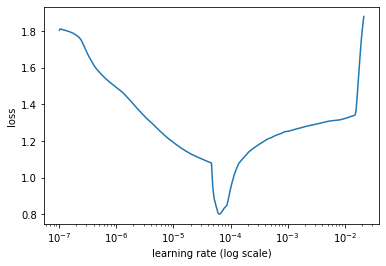


Total time in minutes on estimating optimal learning rate: 
 34.738559521666666


In [43]:
rate_finder_start_time = timeit.default_timer()
roberta_learner_ins_no_neu.lr_find(show_plot=True, max_epochs=3)
rate_finder_stop_time = timeit.default_timer()

print("\nTotal time in minutes on estimating optimal learning rate: \n", (rate_finder_stop_time - rate_finder_start_time)/60)

### Fine Tuning RoBERTa on Emotion Dataset:

We take our emotion dataset along with the RoBERTa model, define the learning-rate & epochs to be used and start fine-tuning.

In [44]:
roberta_fine_tune_start_time = timeit.default_timer()
roberta_learner_ins_no_neu.fit_onecycle(lr=5e-5, epochs=3)
roberta_fine_tune_stop_time = timeit.default_timer()

print("\nTotal time in minutes for Fine-Tuning RoBERTa on Emotion Dataset: \n", (roberta_fine_tune_stop_time - roberta_fine_tune_start_time)/60)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/3
4866/4866 [==============================] - 1058s 215ms/step - loss: 0.7503 - accuracy: 0.7405 - val_loss: 0.6246 - val_accuracy: 0.7899
Epoch 2/3
4866/4866 [==============================] - 1045s 214ms/step - loss: 0.6523 - accuracy: 0.7735 - val_loss: 0.6294 - val_accuracy: 0.7811
Epoch 3/3
4866/4866 [==============================] - 1046s 214ms/step - loss: 0.4871 - accuracy: 0.8296 - val_loss: 0.5800 - val_accuracy: 0.8003

Total time in minutes for Fine-Tuning RoBERTa on Emotion Dataset: 
 52.47507875666667


### Checking RoBERTa performance metrics:

In [45]:
roberta_learner_ins_no_neu.validate()

              precision    recall  f1-score   support

           0       0.69      0.70      0.69       582
           1       0.46      0.44      0.45        81
           2       0.77      0.65      0.71        89
           3       0.87      0.92      0.89      1997
           4       0.74      0.64      0.69       352
           5       0.73      0.64      0.69       559

    accuracy                           0.80      3660
   macro avg       0.71      0.67      0.69      3660
weighted avg       0.80      0.80      0.80      3660



array([[ 405,   25,    4,   87,   24,   37],
       [  24,   36,    3,   10,    3,    5],
       [   8,    1,   58,   15,    5,    2],
       [  54,    1,    4, 1844,   32,   62],
       [  39,   12,    3,   47,  226,   25],
       [  54,    4,    3,  123,   15,  360]], dtype=int64)

In [46]:
roberta_learner_ins_no_neu.validate(class_names=EKMAN_taxonomy_no_neu)

              precision    recall  f1-score   support

       anger       0.69      0.70      0.69       582
     disgust       0.46      0.44      0.45        81
        fear       0.77      0.65      0.71        89
         joy       0.87      0.92      0.89      1997
     sadness       0.74      0.64      0.69       352
    surprise       0.73      0.64      0.69       559

    accuracy                           0.80      3660
   macro avg       0.71      0.67      0.69      3660
weighted avg       0.80      0.80      0.80      3660



array([[ 405,   25,    4,   87,   24,   37],
       [  24,   36,    3,   10,    3,    5],
       [   8,    1,   58,   15,    5,    2],
       [  54,    1,    4, 1844,   32,   62],
       [  39,   12,    3,   47,  226,   25],
       [  54,    4,    3,  123,   15,  360]], dtype=int64)

In [47]:
roberta_learner_ins_no_neu.view_top_losses(preproc=roberta_transformer_no_neu)

----------
id:1966 | loss:7.11 | true:fear | pred:surprise)

----------
id:1585 | loss:6.94 | true:disgust | pred:joy)

----------
id:3024 | loss:6.76 | true:sadness | pred:joy)

----------
id:1464 | loss:6.7 | true:anger | pred:joy)



### Saving RoBERTa Model:

In [48]:
roberta_predictor_no_neu = ktrain.get_predictor(roberta_learner_ins_no_neu.model, preproc=roberta_transformer_no_neu)
roberta_predictor_no_neu.get_classes()

['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

In [49]:
roberta_predictor_no_neu.save('roberta-emotion-predictor_no_neu')

### Loading Saved Model for New Predictions:

In [67]:
roberta_predictor_new_no_neu = ktrain.load_predictor('roberta-emotion-predictor_no_neu')
roberta_predictor_new_no_neu.get_classes()

['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

In [68]:
roberta_predictor_new_no_neu

In [69]:
val_predictions_no_neu = roberta_predictor_new_no_neu.predict(X_val_no_neu.to_list())

In [73]:
val_predictions_no_neu

['surprise',
 'joy',
 'sadness',
 'anger',
 'joy',
 'joy',
 'anger',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'sadness',
 'anger',
 'sadness',
 'anger',
 'anger',
 'surprise',
 'joy',
 'anger',
 'joy',
 'joy',
 'anger',
 'joy',
 'anger',
 'sadness',
 'anger',
 'joy',
 'joy',
 'joy',
 'joy',
 'fear',
 'joy',
 'anger',
 'sadness',
 'sadness',
 'joy',
 'anger',
 'surprise',
 'joy',
 'joy',
 'joy',
 'sadness',
 'surprise',
 'sadness',
 'anger',
 'joy',
 'joy',
 'joy',
 'surprise',
 'sadness',
 'sadness',
 'joy',
 'surprise',
 'sadness',
 'joy',
 'surprise',
 'sadness',
 'surprise',
 'joy',
 'surprise',
 'fear',
 'anger',
 'joy',
 'surprise',
 'joy',
 'joy',
 'joy',
 'joy',
 'anger',
 'joy',
 'anger',
 'anger',
 'anger',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'sadness',
 'joy',
 'joy',
 'joy',
 'sadness',
 'anger',
 'joy',
 'joy',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'joy',
 'joy',
 'joy',
 'joy',
 'surprise',
 'sadness',
 'anger',
 'joy',
 'sadness',
 'anger',
 'joy',
 'j

In [61]:
emotion_label_dict={
0:"anger",
1:"disgust",
2:"fear",
3:"joy",
4:"sadness",
5:"surprise",
6:"neutral"
}

emotion_label_dict_no_neu={
0:"anger",
1:"disgust",
2:"fear",
3:"joy",
4:"sadness",
5:"surprise",
}

In [62]:
y_val_new_no_neu = y_val_no_neu.map(emotion_label_dict_no_neu)

In [63]:
from sklearn.metrics import classification_report
print(classification_report(y_val_new_no_neu, val_predictions_no_neu))

              precision    recall  f1-score   support

       anger       0.69      0.70      0.69       582
     disgust       0.46      0.44      0.45        81
        fear       0.77      0.65      0.71        89
         joy       0.87      0.92      0.89      1997
     sadness       0.74      0.64      0.69       352
    surprise       0.73      0.64      0.69       559

    accuracy                           0.80      3660
   macro avg       0.71      0.67      0.69      3660
weighted avg       0.80      0.80      0.80      3660



### View Performance Metrics on test data:¶

In [51]:
test_predictions_no_neu = roberta_predictor_new_no_neu.predict(X_test_no_neu.to_list())

In [58]:
y_test_new_no_neu = y_test_no_neu.map(emotion_label_dict_no_neu)

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test_new_no_neu, test_predictions_no_neu))

              precision    recall  f1-score   support

       anger       0.70      0.66      0.68       595
     disgust       0.54      0.51      0.53       112
        fear       0.72      0.70      0.71        87
         joy       0.86      0.92      0.89      1915
     sadness       0.73      0.64      0.69       341
    surprise       0.75      0.67      0.71       590

    accuracy                           0.80      3640
   macro avg       0.72      0.69      0.70      3640
weighted avg       0.79      0.80      0.79      3640



In [54]:
test_predictions_1 = roberta_predictor_4.predict(X_test_no_neu.to_list())
val_predictions_1 = roberta_predictor_4.predict(X_val_no_neu.to_list())

In [55]:
test_proba_3 = get_proba(test_predictions_1)
test_proba_3 = np.array(test_proba_3)

val_proba_3 = get_proba(val_predictions_1)
val_proba_3 = np.array(val_proba_3)


In [56]:
# Generate labels
y_pred_labels_test_3 = proba_to_labels(test_proba_3)
y_pred_labels_val_3 = proba_to_labels(val_proba_3)


In [57]:
# Model evaluation
model_eval(y_test_no_neu, y_pred_labels_test_3, GE_taxonomy_no_neu)

,Precision,Recall,F1
admiration,0.75,0.70,0.72
amusement,0.85,0.78,0.81
anger,0.65,0.40,0.50
annoyance,0.52,0.28,0.37
approval,0.55,0.43,0.49
caring,0.62,0.37,0.47
confusion,0.59,0.42,0.49
curiosity,0.74,0.53,0.62
desire,0.74,0.37,0.50
disappointment,0.45,0.21,0.29


In [58]:
# Model evaluation
model_eval(y_val_no_neu, y_pred_labels_val_3, GE_taxonomy_no_neu)

,Precision,Recall,F1
admiration,0.76,0.70,0.73
amusement,0.87,0.74,0.80
anger,0.66,0.41,0.50
annoyance,0.47,0.27,0.35
approval,0.61,0.37,0.46
caring,0.68,0.46,0.55
confusion,0.59,0.40,0.48
curiosity,0.74,0.49,0.59
desire,0.67,0.43,0.52
disappointment,0.54,0.28,0.37


### Modelling ELECTRA

In [34]:
def create_data(text,labels,tokenizer,max_length):

    # Empty Arrays
    input_ids = []
    attention_mask = []
    
    # Loop Through List and Create input ids & attention mask
    for i in tqdm.tqdm(text,total=len(text)):
        x = tokenizer.encode_plus(str(i),
                              return_attention_mask=True,
                              padding='max_length',
                              truncation=True,
                              max_length=max_length,
                              add_special_tokens=True,
                              )
        input_ids.append(x['input_ids'])
        attention_mask.append(x['attention_mask'])
        
    print('Data Shapes : ')
    print(np.array(input_ids).shape,np.array(attention_mask).shape,labels.shape )
    
    return  np.array(input_ids) , np.array(attention_mask) , np.array(labels).reshape(-1,1)

X_train.values, y_train, X_test, y_test, X_val, y_val

In [35]:
X_train.values

array(['my favourite food is anything i did not have to cook myself',
       'now if he does off himself everyone will think hes having a laugh screwing with people instead of actually dead',
       'why the fuck is bayless isoing', ...,
       'what are you talking about ? anything bad that happened was name fault only good things were name doing !',
       'more like a baptism with sexy results !', 'enjoy the ride !'],
      dtype=object)

In [36]:
MODEL_NAME = 'bhadresh-savani/electra-base-emotion'
EPOCHS = 10
MAX_LENGTH = 128
NUM_LABELS = 7

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print('Start Create Train Data')
# Create Train Data
train_ids , train_attention_mask ,train_labels = create_data(X_train.values,
                                                         y_train.values ,
                                                         tokenizer
                                                         ,MAX_LENGTH)
print('Start Create Val Data')
# Create Test Data
val_ids , val_attention_mask ,val_labels = create_data(X_val.values,
                                                      y_val.values,
                                                      tokenizer ,
                                                      MAX_LENGTH
                                                         )
print('Start Create Test Data')
# Create Test Data
test_ids , test_attention_mask ,test_labels = create_data(X_test.values,
                                                      y_test.values,
                                                      tokenizer ,
                                                      MAX_LENGTH
                                                         )

Start Create Train Data


100%|█████████████████████████████████████████████████████████████████████████| 43410/43410 [00:03<00:00, 11496.01it/s]


Data Shapes : 
(43410, 128) (43410, 128) (43410,)
Start Create Val Data


100%|███████████████████████████████████████████████████████████████████████████| 5426/5426 [00:00<00:00, 11443.67it/s]


Data Shapes : 
(5426, 128) (5426, 128) (5426,)
Start Create Test Data


100%|███████████████████████████████████████████████████████████████████████████| 5427/5427 [00:00<00:00, 11546.77it/s]


Data Shapes : 
(5427, 128) (5427, 128) (5427,)


In [49]:
def train_custom_label_model(model_name,num_labels,MAX_LENGTH,Num_epochs):
    
    gc.collect()
    
    my_model = TFAutoModelForSequenceClassification.from_pretrained(model_name,
                                                                    ignore_mismatched_sizes=True
                                                                   ,num_labels=num_labels
                                                                   )
    
    print('FINISH DOWNLOAD MODEL')
#     run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
    my_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=tf.metrics.SparseCategoricalAccuracy(),
#         options = run_opts
        )

    #train , test = train_test_split(df,test_size=.3,random_state=42)


    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    print('FINSH DOWNLOAD TOKENIZER')
    
       
    # Use GPU
    tf.debugging.set_log_device_placement(True)

       
    # Model Checkpoint
    checkpoint_filepath = './'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_sparse_categorical_crossentropy',
        mode='max',
        save_best_only=True,
    )
    
    # Train Model
    my_model.fit([train_ids, train_attention_mask],
                 train_labels,
              validation_split=.3,
              epochs=Num_epochs,
              verbose=1,
              callbacks=[model_checkpoint_callback]
              )
    
    gc.collect()
    
    return my_model

In [78]:
MODEL_NAME = 'bhadresh-savani/electra-base-emotion'
EPOCHS = 3
MAX_LENGTH = 128
NUM_LABELS = 7
learning_rate = 3e-5
electra_model = train_custom_label_model(MODEL_NAME,NUM_LABELS,MAX_LENGTH,EPOCHS)

FINISH DOWNLOAD MODEL
FINSH DOWNLOAD TOKENIZER
Epoch 1/3
1357/1357 [==============================] - 174s 121ms/step - loss: 1.1477 - sparse_categorical_accuracy: 0.6009
Epoch 2/3
1357/1357 [==============================] - 165s 122ms/step - loss: 0.8853 - sparse_categorical_accuracy: 0.6771
Epoch 3/3
1357/1357 [==============================] - 164s 121ms/step - loss: 0.7899 - sparse_categorical_accuracy: 0.7107


In [79]:
print('start testing')
y_h = electra_model.predict([test_ids,test_attention_mask])
print('end testing & start measure errors : ')
y_h = tf.argmax(y_h.logits,axis=1)
print('accuracy score: {:.4f}'.format(accuracy_score(test_labels,y_h)))
print(confusion_matrix(test_labels,y_h))

start testing
end testing & start measure errors : 
accuracy score: 0.6761
[[ 278   18    7   50   28   37  177]
 [  31   47   12    7    2    3   10]
 [   3    1   64    5    4    4    6]
 [  30    2   10 1552   29   43  249]
 [  39    4    4   21  201   21   51]
 [  27    4    9   84   11  363   92]
 [ 118   18   14  221   44  208 1164]]


In [80]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_h) )

              precision    recall  f1-score   support

           0       0.53      0.47      0.50       595
           1       0.50      0.42      0.46       112
           2       0.53      0.74      0.62        87
           3       0.80      0.81      0.81      1915
           4       0.63      0.59      0.61       341
           5       0.53      0.62      0.57       590
           6       0.67      0.65      0.66      1787

    accuracy                           0.68      5427
   macro avg       0.60      0.61      0.60      5427
weighted avg       0.68      0.68      0.68      5427



In [81]:
y_train.shape

(43410,)

In [82]:
# train predictions
y_pred_train_electra = electra_model.predict([train_ids,train_attention_mask])
y_pred_train_electra = tf.argmax(y_pred_train_electra.logits,axis=1)
print(confusion_matrix(y_train,y_pred_train_electra))

[[ 2776   147    36   279   151   195   933]
 [  182   358    47    23    32    10    42]
 [   12    27   510    25    30    15    23]
 [  135    20    34 13710   175   268  1351]
 [  213    48    34   110  2205    79   249]
 [  128    19    58   563    67  3364   508]
 [  780    51    85  1302   251  1423 10327]]


In [83]:
print(classification_report(y_train, y_pred_train_electra) )

              precision    recall  f1-score   support

           0       0.66      0.61      0.64      4517
           1       0.53      0.52      0.52       694
           2       0.63      0.79      0.71       642
           3       0.86      0.87      0.86     15693
           4       0.76      0.75      0.75      2938
           5       0.63      0.71      0.67      4707
           6       0.77      0.73      0.75     14219

    accuracy                           0.77     43410
   macro avg       0.69      0.71      0.70     43410
weighted avg       0.77      0.77      0.77     43410



In [84]:
# val predictions
y_pred_val_electra = electra_model.predict([val_ids,val_attention_mask])
y_pred_val_electra = tf.argmax(y_pred_val_electra.logits,axis=1)
print(confusion_matrix(y_val,y_pred_val_electra))
print(classification_report(y_val, y_pred_val_electra) )

[[ 296   25    4   41   15   22  179]
 [  16   38    4    9    3    2    9]
 [   1    3   62    5    6    2   10]
 [  30    2    5 1621   32   47  260]
 [  24    6    5   33  213   17   54]
 [  21    2    9   82   19  315  111]
 [ 145    8   15  224   38  182 1154]]
              precision    recall  f1-score   support

           0       0.56      0.51      0.53       582
           1       0.45      0.47      0.46        81
           2       0.60      0.70      0.64        89
           3       0.80      0.81      0.81      1997
           4       0.65      0.61      0.63       352
           5       0.54      0.56      0.55       559
           6       0.65      0.65      0.65      1766

    accuracy                           0.68      5426
   macro avg       0.61      0.62      0.61      5426
weighted avg       0.68      0.68      0.68      5426

